In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred
from scipy import optimize as opt
#I'm using Natasha's key :)
fred = Fred(api_key='16fc433e0cb217bb8cb94bf76b981f2f')

## Exercise 1

### Part 1

In [300]:
# Import data
cons = fred.get_series('PCECC96')
gdp_def = fred.get_series('GDPDEF')
wilshire = fred.get_series('WILL5000INDFC')
tbill = fred.get_series('TB3MS')
#wilshire

Note - I'll be throwing out the last period throughout when I do shifts.

In [302]:
'''
Clean data.
Initially:
tbill - monthly from 1934 - 2018
gdp_def - quarterly from 1947 - Jan 2018
wilshire - quarterly from 1971 - 2018
cons - quarterly from 1947 - Jan 2018
'''
#Get Quarterly data for wilshire and tbill
wilshire = wilshire.resample('QS').first()
tbill = tbill.resample('QS').first()

#Calculate risk-free rate
riskfree = tbill/100 + 1

#merge series into a dataframe
df = pd.concat([cons, gdp_def, wilshire, riskfree], axis=1, join='inner')
df.columns = ['cons_r', 'gdp_def', 'wilshire', 'riskfree']

#normalize gdp_def
df['gdp_def'] = df['gdp_def']/100

#Get real vars
df['wilshire_r'] = df['wilshire']/df['gdp_def']
df['R_r'] = df['wilshire_r']/df['wilshire_r'].shift(1)

In [309]:
'''
Define functions to get m and estimate gamma 
'''

def get_empiricalvals(gamma, df, beta):
    '''
    This function calculates an empirical series of ms from cons
    data for a given gamma/beta.
    gamma, beta are scalars
    cseries is a data frame
    '''
    df['m'] = df['cons_r'] ** -gamma / df['cons_r'].shift(1) ** -gamma * beta
    covmR = df['m'][1:].cov(df['R_r'][1:])
    expm = df['m'].mean()
    expR = df['R_r'].mean()
    #df.dropna(axis = 0, inplace = True)
    return df, covmR, expm, expR

def objective(gamma, args):
    '''
    Function gives the sum of least squares for a given gamma under 
    the conditions args (args = df, beta)
    Function calls get_empiricalvals
    '''
    df, beta = args
    df, covmR, expm, expR = get_empiricalvals(gamma, df, beta)
    error = 1 - covmR - expm * expR
    #print(df, covmR, expm, expR, error)
    return error

In [310]:
beta = .99
gammaguess1 = 1
args = [df, beta]

#df['cons_()']
result = opt.root(objective, gammaguess1, args=args)
gamma_est1 = result.x
print(f"Estimated gamma is {gamma_est1}")

Estimated gamma is [1.32635712]


### Part 2

This parameter looks reasonable to me - I've definitely seen gammas like this in the CRRA utility function. I don't know of any other checks for 

### Part 3

In [305]:
#Define moment error
def riskfreeerror(gamma, args):
    '''
    Function gives the sum of squared errors of the moment conditions
    for each time period for a given gamma.
    '''
    df, beta = args
    df, covmR, expm, expR = get_empiricalvals(gamma, df, beta)
    df['err'] = df['riskfree'] - 1/expm
    sqerr = np.sum((df['err'])**2)
    return sqerr    

In [306]:
beta = .99
gammaguess1 = 1
args = [df, beta]

results = opt.minimize(riskfreeerror, gammaguess1, args)
gamma_est2 = results.x
#df['riskfree']
gamma_est2

array([4.84443948])

Which is a very different estimate from the preivous one!

### Part 4

In [324]:
#First thing is to define an error function

def errvec4(params, df):
    '''
    This function gets the error from equation 5 and equation 7
    (which were used in the last problem) and puts them into a 
    length-2 error vector for a given gamma, beta = params. 
    '''
    beta, gamma = params
    df, covmR, expm, expR = get_empiricalvals(gamma, df, beta)
    error5 = 1 - covmR - expm * expR
    df['err7s'] = df['riskfree'] - 1/expm
    error7 = np.sum((df['err7s'])**2)
    errvec = np.array([error5, error7])
    return errvec

def crit(params, args):
    '''
    Criterion function to minimize
    args includes df and a weighting matrix W
    '''
    df, W = args
    errvec = errvec4(params, df)
    out = np.sum(errvec**2)
    return out

In [345]:
betaguess4 = 1
gammaguess4 = 3
W  = np.eye(2)
params = [betaguess4, gammaguess4]
args = [df, W]

results = opt.minimize(crit, params, args=args, bounds = ((None, 1), (None, None)))
beta_est4, gamma_est4 = results.x
print(f"Estimated beta: {beta_est4} \nEstimated gamma: {gamma_est4}")
results.fun

Estimated beta: 0.9769327147685942 
Estimated gamma: 3.00017068507085


0.049977353539514324

Text(0,0.5,'gamma')

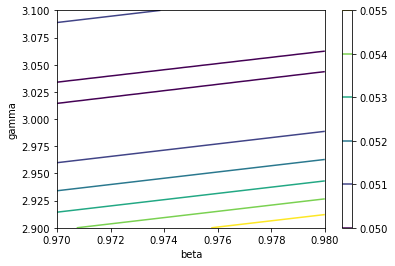

In [346]:
#Plot
#Initialize grids
res = 100
betagrid = np.linspace(.97, .98, res)
gammagrid = np.linspace(2.9, 3.1, res)
X, Y = np.meshgrid(betagrid, gammagrid)

#Calculate function vals
args = [df, W]
Z = np.zeros((res, res))
for i in range(res):
    for j in range(res):
        params = [betagrid[i], gammagrid[j]]
        Z[i,j] = crit(params, args)

plt.contour(X, Y, Z, 5)
plt.colorbar()
plt.xlabel('beta')
plt.ylabel('gamma')

### Return to this plot 